In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [ ]:
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
sobel = torch.tensor([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]], dtype=torch.float32)

sobel = sobel.view(1, 1, 3, 3)

conv = nn.Conv2d(1, 1, 3, 1)

with torch.no_grad():
    conv.weight = nn.Parameter(sobel)

In [ ]:
for i, (X_train, y_train) in enumerate(train_data):
  break

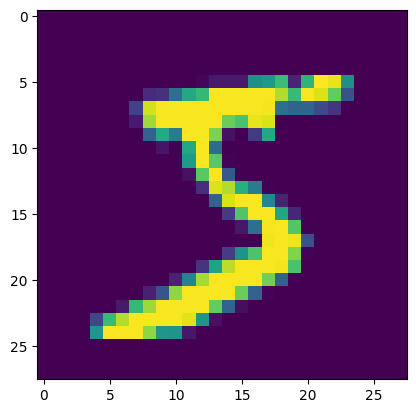

In [ ]:
plt.imshow(X_train.reshape(28, 28))

In [ ]:
X_train.shape

torch.Size([1, 28, 28])

In [ ]:
x = X_train.view(1, 1, 28, 28)
x = F.relu(conv(x))

In [ ]:
x.shape

torch.Size([1, 1, 26, 26])

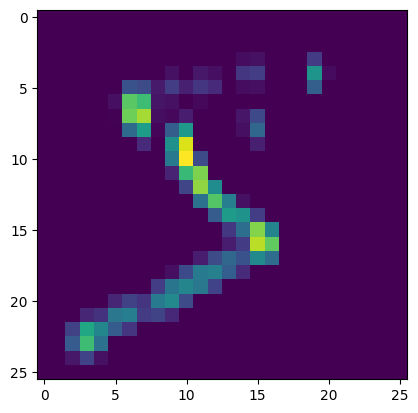

In [ ]:
plt.imshow(x.detach().reshape(26, 26))

In [ ]:
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 1, 13, 13])

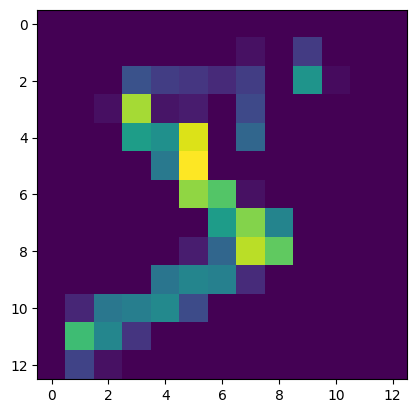

In [ ]:
plt.imshow(x.detach().reshape(13, 13))

In [ ]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    sobel = torch.tensor([[-1, 0, 1],
                          [-2, 0, 2],
                          [-1, 0, 1]], dtype=torch.float32)
    sobel = sobel.view(1, 1, 3, 3)
    self.conv = nn.Conv2d(1, 1, 3, 1)
    with torch.no_grad():
      self.conv.weight = nn.Parameter(sobel)
    self.fc1 = nn.Linear(169, 80) # 13 * 13 = 169
    self.fc2 = nn.Linear(80, 10)

  def forward(self, X):
    X = F.relu(self.conv(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 169)

    X = F.relu(self.fc1(X))
    X = self.fc2(X)
    return F.log_softmax(X, dim=1)

In [ ]:
torch.manual_seed(282)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=169, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)

In [ ]:
def reset_weights(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
    m.reset_parameters()

In [ ]:
criterion = nn.CrossEntropyLoss()
model.apply(reset_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
X_test_list = []
y_test_list = []

for i in range(len(test_data)):
    image, label = test_data[i]
    X_test_list.append(image)
    y_test_list.append(label)

X_test = torch.stack(X_test_list)
y_test = torch.tensor(y_test_list)

In [ ]:
epochs = 5
trainLosses = []
testLosses = []
trainCorrect = []
testCorrect = []
model.train()

for i in range(epochs):
  train_correct = 0
  test_correct = 0
  for batch_id, (X_train, y_train) in enumerate(train_loader):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    train_correct += (predicted == y_train).sum()

    loss.backward()
    optimizer.step()

  trainLosses.append(loss)
  trainCorrect.append(train_correct)
  print("Epoch ", i, " Train Loss ", loss.item() / len(y_train))

  with torch.no_grad():
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    test_correct += (predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  testLosses.append(loss)
  testCorrect.append(test_correct)
  print("Epoch ", i, " Test Accuracy ", test_correct.item() / len(y_test), " Test Loss " , loss.item())

  print("Done with epoch ", i)

Epoch  0  Train Loss  0.01073323842138052
Epoch  0  Test Accuracy  0.9343  Test Loss  0.21553204953670502
Done with epoch  0
Epoch  1  Train Loss  0.0014397777849808335
Epoch  1  Test Accuracy  0.9553  Test Loss  0.1451335996389389
Done with epoch  1
Epoch  2  Train Loss  0.009962206706404686
Epoch  2  Test Accuracy  0.9615  Test Loss  0.12631148099899292
Done with epoch  2
Epoch  3  Train Loss  0.0023158101830631495
Epoch  3  Test Accuracy  0.9664  Test Loss  0.11135372519493103
Done with epoch  3
Epoch  4  Train Loss  0.0086597865447402
Epoch  4  Test Accuracy  0.971  Test Loss  0.09661318361759186
Done with epoch  4


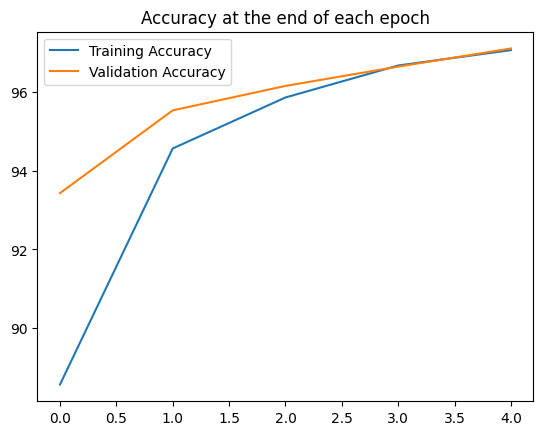

In [ ]:
plt.plot([t/600 for t in trainCorrect], label="Training Accuracy")
plt.plot([t/100 for t in testCorrect], label="Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

Text(0.5, 1.0, 'Validation Loss at each epoch')

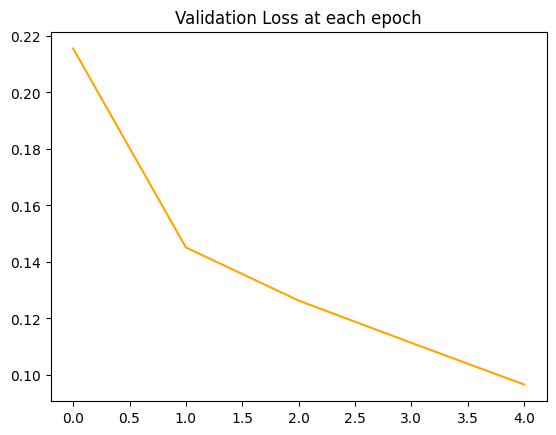

In [ ]:
plt.plot(testLosses, label="Validation Loss", color='orange')
plt.title("Validation Loss at each epoch")

In [ ]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[694][0].view(1,1,28,28))

tensor([[-2.4676e+01, -2.2110e+01, -2.0335e+01, -1.9395e+01, -2.1418e+01,
         -4.4345e-05, -2.2704e+01, -2.7435e+01, -1.0024e+01, -2.5772e+01]])
Predicted: tensor(5)
Actual number: tensor(5)


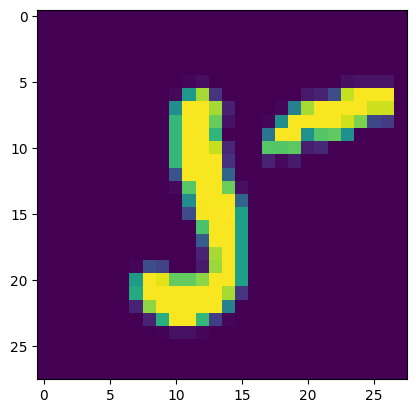

In [ ]:
plt.imshow(test_data[694][0].reshape(28,28))
print(new_prediction)
print("Predicted:", new_prediction.argmax())
print("Actual number:", y_test[694])

In [ ]:
torch.save(model.state_dict(), 'myConvNetwork.pth')

In [ ]:
batch_sizes = [10, 64, 128, 5000, 60000]

models = []

for batch_size in batch_sizes:
    newModel = ConvolutionalNetwork()
    newModel.apply(reset_weights)
    models.append(newModel)

train_loaders = [
    DataLoader(train_data, batch_size=batch_size, shuffle=True)
    for batch_size in batch_sizes
]

model_metrics = {}

for i, newModel in enumerate(models):
    optimizer = torch.optim.Adam(newModel.parameters(), lr=0.001)
    train_loader = train_loaders[i]

    print(f"Training model with batch size: {batch_sizes[i]}")

    testNewLosses = []
    testNewCorrect = []

    for epoch in range(epochs):
      test_correct = 0
      for batch_id, (X_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = newModel(X_train)
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]

        loss.backward()
        optimizer.step()

      with torch.no_grad():
        y_val = newModel(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        test_correct += (predicted == y_test).sum()

      loss = criterion(y_val, y_test)
      testNewLosses.append(loss)
      testNewCorrect.append(test_correct)
      print("Epoch ", epoch, " Test Accuracy ", test_correct.item() / len(y_test), " Test Loss " , loss.item())

      print("Done with epoch ", epoch)

    model_metrics[batch_sizes[i]] = {
        'testLosses': testNewLosses,
        'testCorrect': testNewCorrect
    }

Training model with batch size: 10
Epoch  0  Test Accuracy  0.9534  Test Loss  0.15160569548606873
Done with epoch  0
Epoch  1  Test Accuracy  0.9637  Test Loss  0.11748526245355606
Done with epoch  1
Epoch  2  Test Accuracy  0.9642  Test Loss  0.11460559070110321
Done with epoch  2
Epoch  3  Test Accuracy  0.9682  Test Loss  0.10203998535871506
Done with epoch  3
Epoch  4  Test Accuracy  0.9719  Test Loss  0.09173800051212311
Done with epoch  4
Training model with batch size: 64
Epoch  0  Test Accuracy  0.9209  Test Loss  0.27230629324913025
Done with epoch  0
Epoch  1  Test Accuracy  0.9388  Test Loss  0.19363676011562347
Done with epoch  1
Epoch  2  Test Accuracy  0.9501  Test Loss  0.15934999287128448
Done with epoch  2
Epoch  3  Test Accuracy  0.96  Test Loss  0.12838846445083618
Done with epoch  3
Epoch  4  Test Accuracy  0.9629  Test Loss  0.11659184843301773
Done with epoch  4
Training model with batch size: 128
Epoch  0  Test Accuracy  0.1135  Test Loss  2.3011653423309326
Don

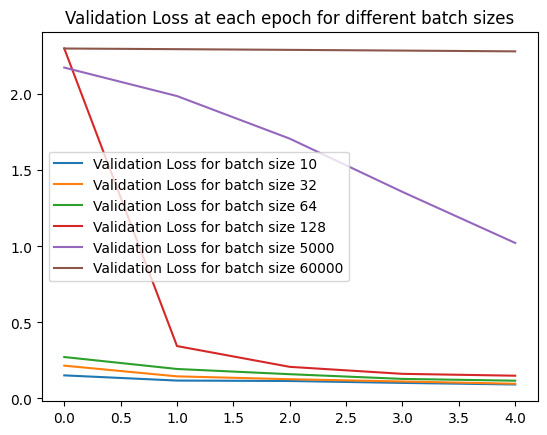

In [ ]:
plt.plot(model_metrics[10]['testLosses'], label="Validation Loss for batch size 10")
plt.plot(testLosses, label="Validation Loss for batch size 32")
plt.plot(model_metrics[64]['testLosses'], label="Validation Loss for batch size 64")
plt.plot(model_metrics[128]['testLosses'], label="Validation Loss for batch size 128")
plt.plot(model_metrics[5000]['testLosses'], label="Validation Loss for batch size 5000")
plt.plot(model_metrics[60000]['testLosses'], label="Validation Loss for batch size 60000")
plt.title("Validation Loss at each epoch for different batch sizes")
plt.legend()

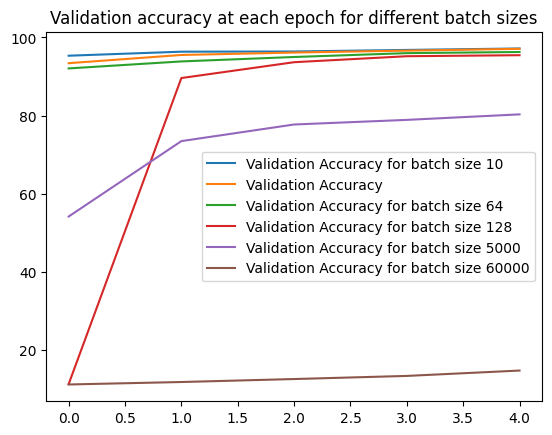

In [ ]:
plt.plot([t/100 for t in model_metrics[10]['testCorrect']], label="Validation Accuracy for batch size 10")
plt.plot([t/100 for t in testCorrect], label="Validation Accuracy")
plt.plot([t/100 for t in model_metrics[64]['testCorrect']], label="Validation Accuracy for batch size 64")
plt.plot([t/100 for t in model_metrics[128]['testCorrect']], label="Validation Accuracy for batch size 128")
plt.plot([t/100 for t in model_metrics[5000]['testCorrect']], label="Validation Accuracy for batch size 5000")
plt.plot([t/100 for t in model_metrics[60000]['testCorrect']], label="Validation Accuracy for batch size 60000")
plt.title("Validation accuracy at each epoch for different batch sizes")
plt.legend()

Kao što vidimo, za veličine 10 i 32 dobiju se gotovo isti rezultati nakon 5 epoha. Ipak, za manji broj epoha veličina batcha 10 pokazuje se nešto efikasnijom. Za svaku sljedeću veličinu efikasnost je sve manja.